In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
import os
import json
import shutil

def convert_yolo_to_corners(x_center, y_center, width, height, img_width, img_height):
    x_center, width = x_center * img_width, width * img_width
    y_center, height = y_center * img_height, height * img_height
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    return [x_min, y_min, x_max, y_max]

def convert_yolo_annotations(base_dir, subsets, output_dir):
    for subset in subsets:
        images_dir = os.path.join(base_dir, subset, 'images')
        labels_dir = os.path.join(base_dir, subset, 'labels')
        json_data = []

        # Create output directories for images, labels, and JSON files
        subset_output_dir = os.path.join(output_dir, subset)
        images_output_dir = os.path.join(subset_output_dir, 'images')
        labels_output_dir = os.path.join(subset_output_dir, 'labels')
        os.makedirs(images_output_dir, exist_ok=True)
        os.makedirs(labels_output_dir, exist_ok=True)

        for filename in os.listdir(images_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                # Copy images
                src_image_path = os.path.join(images_dir, filename)
                dst_image_path = os.path.join(images_output_dir, filename)
                shutil.copy(src_image_path, dst_image_path)

                # Handle labels and convert annotations
                label_file = os.path.join(labels_dir, filename.rsplit('.', 1)[0] + '.txt')
                dst_label_path = os.path.join(labels_output_dir, filename.rsplit('.', 1)[0] + '.txt')
                if os.path.exists(label_file):
                    shutil.copy(label_file, dst_label_path)  # Copy label files

                    with open(label_file, 'r') as file:
                        image = Image.open(src_image_path)
                        img_width, img_height = image.size
                        image_data = {
                            'filename': filename,
                            'path': dst_image_path,
                            'boxes': [],
                            'labels': []
                        }
                        for line in file:
                            parts = line.strip().split()
                            class_id = int(parts[0])
                            x_center, y_center, width, height = map(float, parts[1:])
                            box = convert_yolo_to_corners(x_center, y_center, width, height, img_width, img_height)
                            image_data['labels'].append(class_id)
                            image_data['boxes'].append(box)
                        json_data.append(image_data)

        # Write JSON annotation file
        with open(os.path.join(subset_output_dir, 'annotations.json'), 'w') as json_file:
            json.dump(json_data, json_file, indent=4)

# Usage
base_dir = '/kaggle/input/datasetziiip/structured_dataset'
output_dir = '/kaggle/working/structured_dataset'
subsets = ['train', 'val', 'test']
convert_yolo_annotations(base_dir, subsets, output_dir)


In [3]:
import os
from PIL import Image
import json

def update_json_with_dimensions(json_file, img_dir):
    # Load existing data
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Update each entry with image dimensions
    for item in data:
        img_path = os.path.join(img_dir, item['filename'])
        with Image.open(img_path) as img:
            item['original_width'], item['original_height'] = img.size

    # Save updated data
    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)

# Example usage
base_dir = '/kaggle/working/structured_dataset/train'
json_file = os.path.join(base_dir, 'annotations.json')
img_dir = os.path.join(base_dir, 'images')
update_json_with_dimensions(json_file, img_dir)
base_dir = '/kaggle/working/structured_dataset/test'
json_file = os.path.join(base_dir, 'annotations.json')
img_dir = os.path.join(base_dir, 'images')
update_json_with_dimensions(json_file, img_dir)
base_dir = '/kaggle/working/structured_dataset/val'
json_file = os.path.join(base_dir, 'annotations.json')
img_dir = os.path.join(base_dir, 'images')
update_json_with_dimensions(json_file, img_dir)

In [4]:
import json
import os

def test_annotation_conversion(base_dir, subset):
    json_file_path = os.path.join(base_dir, subset, 'annotations.json')
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    errors = []
    for item in data:
        # Check for necessary keys
        if not all(key in item for key in ['filename', 'path', 'boxes', 'labels']):
            errors.append(f"Missing keys in item: {item['filename']}")

        # Check bounding box format
        for box in item['boxes']:
            if not len(box) == 4 or not all(isinstance(x, (int, float)) for x in box):
                errors.append(f"Invalid box format in {item['filename']}: {box}")

    return errors

# Usage
base_dir = '/kaggle/working/structured_dataset'
subsets = ['train', 'val', 'test']
for subset in subsets:
    errors = test_annotation_conversion(base_dir, subset)
    if errors:
        print(f"Errors in {subset}:")
        for error in errors:
            print(error)
    else:
        print(f"No errors found in {subset}. Annotation conversion seems correct.")


No errors found in train. Annotation conversion seems correct.
No errors found in val. Annotation conversion seems correct.
No errors found in test. Annotation conversion seems correct.


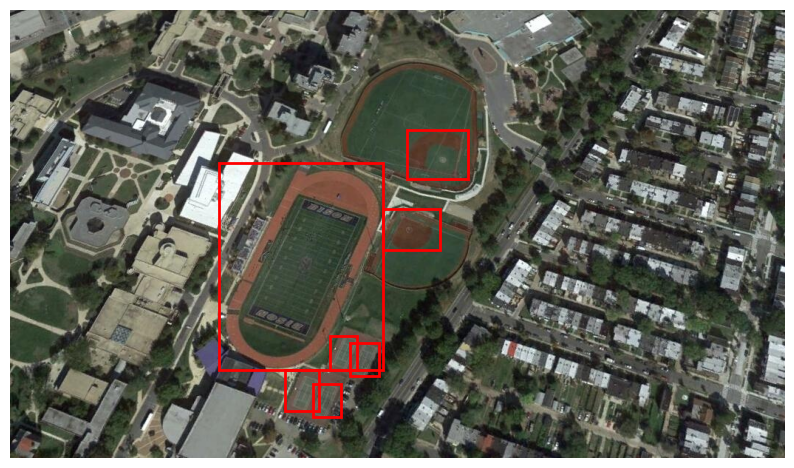

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json

def visualize_annotations(image_path, boxes):
    """Visualize bounding boxes on an image."""
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Example usage for one image
with open('/kaggle/working/structured_dataset/train/annotations.json') as f:
    data = json.load(f)
    item = data[0]  # Modify as needed to select different images
    visualize_annotations(item['path'], item['boxes'])

In [6]:
pip install torch torchvision pillow

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
import torch
import os
import json
from PIL import Image
import torchvision.transforms as transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, json_file, img_dir, transform=None):
        with open(json_file) as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_info = self.data[idx]
        img_path = os.path.join(self.img_dir, img_info['filename'])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Resizing factor, assuming images are resized to (800, 800) during transformation
        original_size = (img_info['original_width'], img_info['original_height'])
        new_size = (800, 800)

        # Adjust bounding boxes
        boxes = []
        for box in img_info['boxes']:
            xmin, ymin, xmax, ymax = box
            xmin = xmin / original_size[0] * new_size[0]
            xmax = xmax / original_size[0] * new_size[0]
            ymin = ymin / original_size[1] * new_size[1]
            ymax = ymax / original_size[1] * new_size[1]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.tensor(boxes, dtype=torch.float32)

        labels = torch.tensor(img_info['labels'], dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target

# Example transformation (resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def custom_collate_fn(batch):
    # Filter out any samples that may have been returned as None
    batch = [data for data in batch if data is not None]

    # Extract images and targets from the batch
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Since images are likely the same size (assuming the same transforms were applied), you can stack them
    images = torch.stack(images, dim=0)

    # Do not attempt to stack targets directly since they might have different lengths
    # Simply leave them as a list of dictionaries
    return images, targets
# Example usage
base_dir = '/kaggle/working/structured_dataset'
train_json = os.path.join(base_dir, 'train', 'annotations.json')
val_json = os.path.join(base_dir, 'val', 'annotations.json')
test_json = os.path.join(base_dir, 'test', 'annotations.json')
train_img_dir = os.path.join(base_dir, 'train', 'images')
val_img_dir = os.path.join(base_dir, 'val', 'images')
test_img_dir = os.path.join(base_dir, 'test', 'images')

# Create datasets
train_dataset = CustomDataset(train_json, train_img_dir, transform)
val_dataset = CustomDataset(val_json, val_img_dir, transform)
test_dataset = CustomDataset(test_json, test_img_dir, transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=40, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=custom_collate_fn)

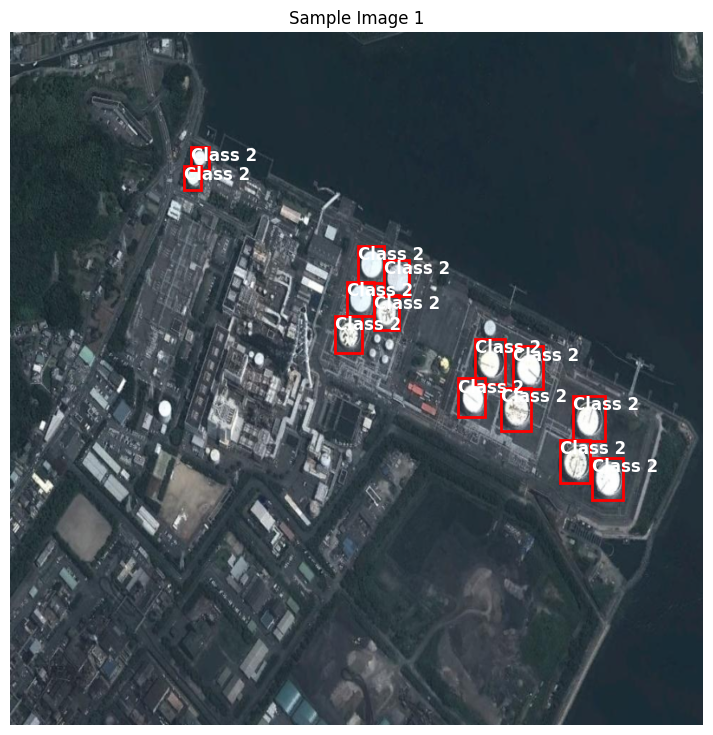

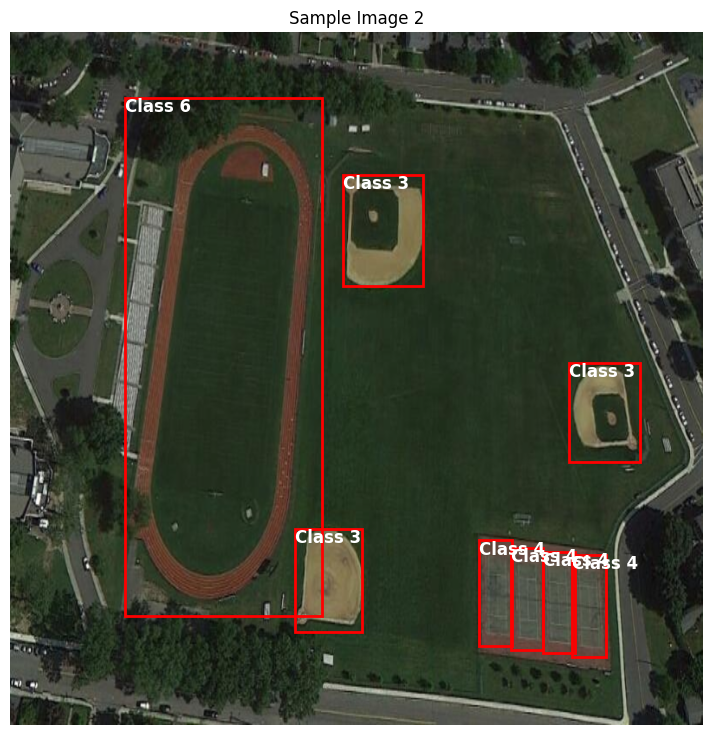

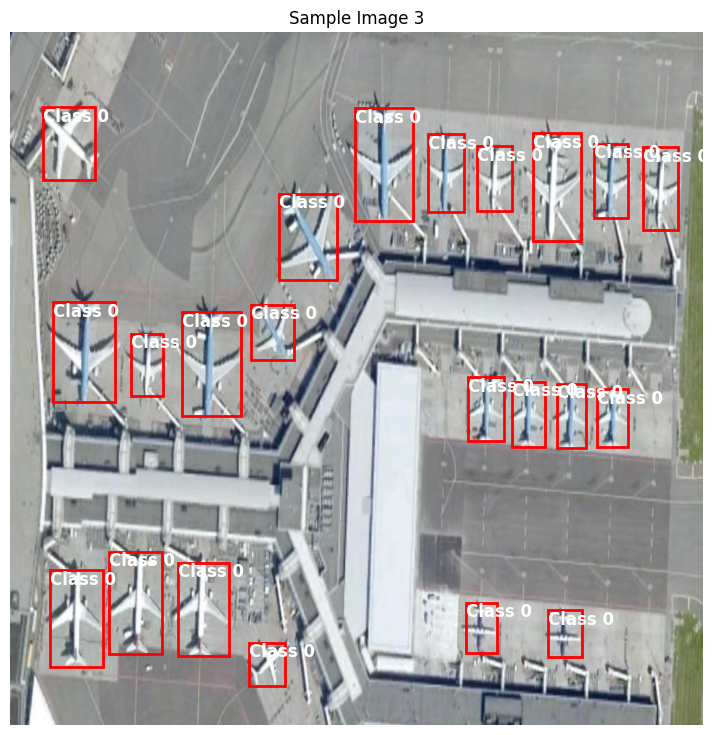

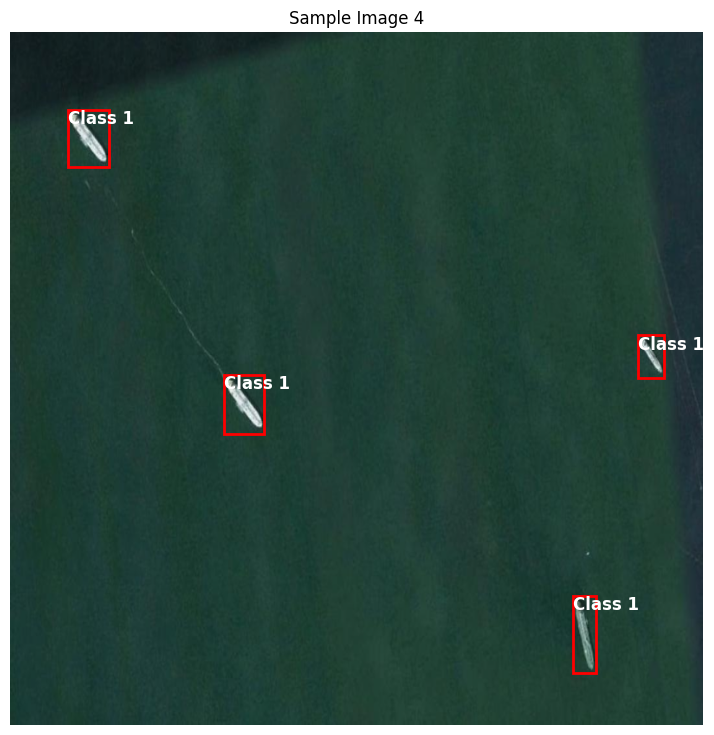

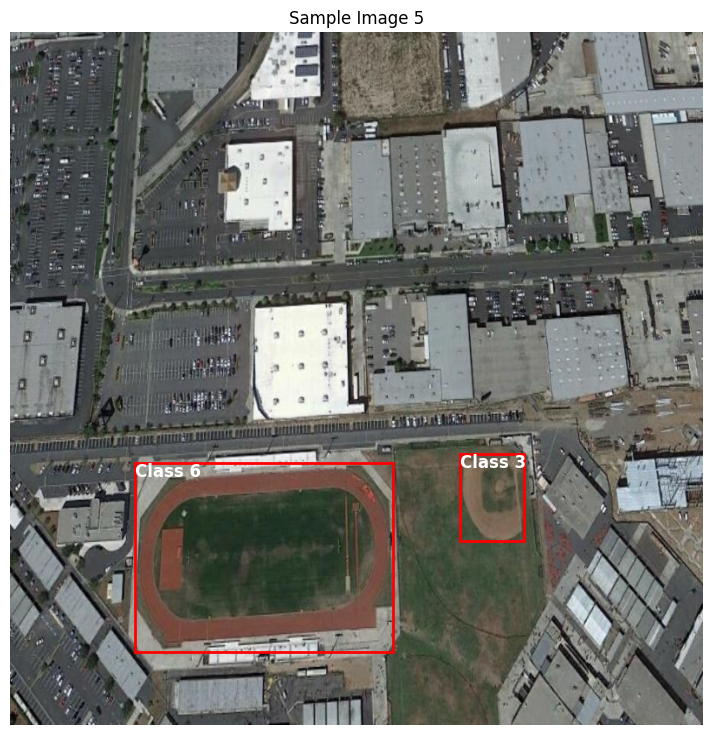

In [9]:
# Visualization function as defined previously
def show_image_with_boxes(image, target, title=""):
    image = image.permute(1, 2, 0)  # Change C,H,W to H,W,C for matplotlib
    image = (image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])).clamp(0, 1)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='r', linewidth=2, facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Class {label}', verticalalignment='top', color='white', fontsize=12, weight='bold')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Testing the data loading and visualization
for images, targets in val_loader:
    for i in range(min(len(images), 5)):  # Display up to 3 images from the dataset
        show_image_with_boxes(images[i], targets[i], title=f"Sample Image {i + 1}")
    break  # Only process the first batch

In [ ]:
# Example usage
for images, targets in train_loader:
    # Your training logic here
    print(images.shape, targets)

In [11]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # Load a pre-trained model
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)

    # Correctly configure the anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),  # One size for each feature map
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Same aspect ratios for each feature map level
    )

    # Create the Faster R-CNN model
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator)

    # Replace the classifier with a new one for your specific number of classes (including the background)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Number of classes (e.g., 10 classes + 1 background)
num_classes = 11
model = create_model(num_classes)

# Example optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import functional as F
import numpy as np
from torch.utils.data import DataLoader

# Assume 'model' and 'optimizer' are already defined and configured
# Assume 'train_loader' and 'val_loader' are defined DataLoader instances for your training and validation datasets

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Number of epochs to train for
num_epochs = 30

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    return running_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    running_loss = 0.0
    total = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Ensure model is in evaluation mode which might change its return values
            model.eval()
            outputs = model(images, targets)

            # If model returns a dictionary of losses (which is typical during training)
            if isinstance(outputs, dict):
                losses = sum(loss for loss in outputs.values())
                running_loss += losses.item()
                total += 1

    return running_loss / total if total > 0 else 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

In [ ]:
torch.save(model.state_dict(),f'model_{30}.pt')

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

In [ ]:
import torch

def make_prediction(model, images, device, threshold=0.5):
    # Ensure the model is in evaluation mode
    model.eval()

    # Move images to the correct device
    images = [img.to(device) for img in images]

    # No gradient computation for inference
    with torch.no_grad():
        predictions = model(images)

    # Filter out predictions below the threshold
    for prediction in predictions:
        idx_list = [idx for idx, score in enumerate(prediction['scores']) if score > threshold]

        prediction['boxes'] = prediction['boxes'][idx_list]
        prediction['labels'] = prediction['labels'][idx_list]
        prediction['scores'] = prediction['scores'][idx_list]

    return predictions

# Example usage
# Assuming data_loader is your validation/test DataLoader
for images, targets in test_loader:
    preds = make_prediction(model, images, device='cuda', threshold=0.5)
    break  # Just do it for one batch for demonstration